In [1]:
%load_ext autoreload 
%autoreload 2

# Exp8 Pretrain Patch DCGAN to obtain feature extractor (fundus)

In [2]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from networks import weights_init, Generator_64, Discriminator_64, Generator_128_v2, Discriminator_128_v2, Discriminator_128_v2_PatchGAN, Discriminator_128_v2_DC_PatchGAN
from loader import All_fundus_files

In [3]:
# settings
dataroot = "data/celeba"
batch_size = 128
image_size = 128 #size using data aug.

ch_out = 3 
ch_noise = 100
ch_g = 64
ch_d = 64

num_epochs = 100
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# dataloader
'''
train_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
'''
train_dataset = All_fundus_files(transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
print(len(train_dataset))

# networks
#net_G = Generator_64(ch_noise, ch_g, ch_out).to(device)
net_G = Generator_128_v2(ch_noise, ch_g, ch_out).to(device)
net_G.apply(weights_init)
print(net_G)

#net_D = Discriminator_64(ch_out, ch_d).to(device)
net_D = Discriminator_128_v2_DC_PatchGAN(ch_out, ch_d).to(device)
net_D.apply(weights_init)
print(net_D)

# loss and optimizer
wei = 0.1
criterion = nn.BCELoss()
criterion2 = nn.MSELoss()
optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(beta1, 0.999))
lr_scheduler_G = optim.lr_scheduler.MultiStepLR(optimizer_D, [20,60,90], gamma=0.1)
lr_scheduler_D = optim.lr_scheduler.MultiStepLR(optimizer_G, [20,60,90], gamma=0.1)

41317
41317
Generator_128_v2(
  (backbone): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=

In [5]:
from torchsummary import summary
summary(net_D, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
    InstanceNorm2d-4          [-1, 128, 32, 32]               0
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
    InstanceNorm2d-7          [-1, 256, 16, 16]               0
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 4, 4]               0
        LeakyReLU-14           [-1, 102

In [6]:
def cv2_imwrite(path, image):
    image = np.clip(np.round(image*255),0,255)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

### Adding tricks to improve convergence
# https://github.com/soumith/ganhacks
# adding soft label and label noise
def train_one_epoch(epoch, dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device):
    G_losses = []
    D_losses = []
    for iteration, data in enumerate(dataloader, 0):
        ### Update D
        net_G.train()
        net_D.train()
        #data
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label_tmp = torch.rand((batch_size,))*0.5+0.7 #use soft label
        
        noise = torch.randn(batch_size, ch_noise, 1, 1, device=device) #(b,c,1,1)
        fake_data = net_G(noise)
        #fake_label = torch.zeros((batch_size,), dtype=torch.float, device=device)
        fake_label_tmp = torch.rand((batch_size,))*0.3
        
        if torch.rand(1) < 0.05: #add label noise
            real_label = fake_label_tmp.to(device)
            fake_label = real_label_tmp.to(device)
        else:
            real_label = real_label_tmp.to(device)
            fake_label = fake_label_tmp.to(device)
        
        #forward
        real_output, real_output2 = net_D(real_data)
        fake_output, fake_output2 = net_D(fake_data.detach())
        real_loss_D = criterion(real_output, real_label) + wei * criterion2(real_output2, real_label)
        fake_loss_D = criterion(fake_output, fake_label) + wei * criterion2(fake_output2, fake_label)
        loss_D = real_loss_D + fake_loss_D
        
        #backward
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        

        ### Update G
        #real_label = torch.ones((batch_size,), dtype=torch.float, device=device)
        real_label = torch.rand((batch_size,))*0.5+0.7
        real_label = real_label.to(device)
        fake_output_G, fake_output_G2 = net_D(fake_data)
        loss_G = criterion(fake_output_G, real_label) + wei * criterion2(fake_output_G2, real_label)
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
        # logs
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        if iteration % 50 == 0:
            print('[{:d}/{:d}] Iter:{:d}  Loss_D={:.4f} Loss_G={:.4f} D(x)={:.4f} D(G(z))={:.4f}, {:.4f}'.format(
                  epoch, num_epochs, iteration+1, loss_D.item(), loss_G.item(), real_output.mean().item(), fake_output.mean().item(), fake_output_G.mean().item()))
        
        # test
        if (iteration == len(dataloader)//2) or (iteration == len(dataloader)-1):
            net_G.eval()
            net_D.eval()
            with torch.no_grad():
                fake_images = net_G(fixed_noise).detach().cpu()
            fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
            #print(fake_images)
            cv2_imwrite('./fig_exp8/epoch{}Iter{}.png'.format(epoch, iteration), fake_images.numpy())
    return G_losses, D_losses


In [7]:
# Training
G_losses = []
D_losses = []
fixed_noise = torch.randn(64, ch_noise, 1, 1, device=device)
# For each epoch
for epoch in range(num_epochs):
    g,d = train_one_epoch(epoch, train_dataloader, net_G, net_D, optimizer_G, optimizer_D, num_epochs, fixed_noise, ch_noise, device)
    G_losses += g
    D_losses += d
    lr_scheduler_G.step()
    lr_scheduler_D.step()

[0/100] Iter:1  Loss_D=2.3774 Loss_G=1.5246 D(x)=0.2568 D(G(z))=0.0894, 0.9900
[0/100] Iter:51  Loss_D=68.2960 Loss_G=9.8246 D(x)=0.9821 D(G(z))=1.0000, 0.0002
[0/100] Iter:101  Loss_D=7.1851 Loss_G=44.6924 D(x)=0.9298 D(G(z))=0.0000, 0.0000
[0/100] Iter:151  Loss_D=45.8913 Loss_G=39.0365 D(x)=0.9970 D(G(z))=0.0000, 0.0000
[0/100] Iter:201  Loss_D=2.8830 Loss_G=9.5385 D(x)=0.7679 D(G(z))=0.0000, 0.0001
[0/100] Iter:251  Loss_D=0.9994 Loss_G=1.9723 D(x)=0.7216 D(G(z))=0.2640, 0.1510
[0/100] Iter:301  Loss_D=1.1428 Loss_G=1.6871 D(x)=0.7345 D(G(z))=0.3722, 0.2141
[1/100] Iter:1  Loss_D=1.2547 Loss_G=2.8561 D(x)=0.8771 D(G(z))=0.5979, 0.0752
[1/100] Iter:51  Loss_D=0.9848 Loss_G=2.0899 D(x)=0.8043 D(G(z))=0.4210, 0.1373
[1/100] Iter:101  Loss_D=1.4489 Loss_G=1.1988 D(x)=0.6125 D(G(z))=0.0828, 0.3632
[1/100] Iter:151  Loss_D=0.9723 Loss_G=1.5098 D(x)=0.7770 D(G(z))=0.2872, 0.2343
[1/100] Iter:201  Loss_D=1.0861 Loss_G=2.9424 D(x)=0.8585 D(G(z))=0.4607, 0.0658
[1/100] Iter:251  Loss_D=0.862

[14/100] Iter:201  Loss_D=1.4029 Loss_G=1.0556 D(x)=0.4999 D(G(z))=0.3502, 0.3784
[14/100] Iter:251  Loss_D=1.0101 Loss_G=1.3438 D(x)=0.7281 D(G(z))=0.3177, 0.2847
[14/100] Iter:301  Loss_D=1.3262 Loss_G=1.0222 D(x)=0.5965 D(G(z))=0.4350, 0.3902
[15/100] Iter:1  Loss_D=0.9256 Loss_G=1.4038 D(x)=0.7420 D(G(z))=0.2946, 0.2710
[15/100] Iter:51  Loss_D=1.3061 Loss_G=2.3034 D(x)=0.8201 D(G(z))=0.6175, 0.1161
[15/100] Iter:101  Loss_D=1.0054 Loss_G=1.7452 D(x)=0.7610 D(G(z))=0.3570, 0.1981
[15/100] Iter:151  Loss_D=0.9148 Loss_G=1.4452 D(x)=0.7796 D(G(z))=0.3878, 0.2684
[15/100] Iter:201  Loss_D=1.1191 Loss_G=1.1874 D(x)=0.6799 D(G(z))=0.3641, 0.3305
[15/100] Iter:251  Loss_D=0.9637 Loss_G=1.5101 D(x)=0.8040 D(G(z))=0.4424, 0.2512
[15/100] Iter:301  Loss_D=1.0054 Loss_G=1.6955 D(x)=0.7750 D(G(z))=0.3862, 0.2067
[16/100] Iter:1  Loss_D=1.0669 Loss_G=2.0958 D(x)=0.8344 D(G(z))=0.5053, 0.1394
[16/100] Iter:51  Loss_D=1.3542 Loss_G=2.4740 D(x)=0.8451 D(G(z))=0.6430, 0.1025
[16/100] Iter:101  Los

[29/100] Iter:1  Loss_D=0.7777 Loss_G=1.3770 D(x)=0.8311 D(G(z))=0.2776, 0.2756
[29/100] Iter:51  Loss_D=0.9218 Loss_G=1.3135 D(x)=0.7720 D(G(z))=0.3087, 0.2919
[29/100] Iter:101  Loss_D=0.7506 Loss_G=1.6359 D(x)=0.8622 D(G(z))=0.2459, 0.2160
[29/100] Iter:151  Loss_D=0.8191 Loss_G=1.4428 D(x)=0.8247 D(G(z))=0.2752, 0.2604
[29/100] Iter:201  Loss_D=0.7590 Loss_G=1.6611 D(x)=0.8467 D(G(z))=0.2390, 0.2147
[29/100] Iter:251  Loss_D=0.7939 Loss_G=1.5026 D(x)=0.8168 D(G(z))=0.2170, 0.2445
[29/100] Iter:301  Loss_D=0.7881 Loss_G=1.5185 D(x)=0.8239 D(G(z))=0.2469, 0.2475
[30/100] Iter:1  Loss_D=0.7976 Loss_G=1.5012 D(x)=0.8504 D(G(z))=0.2745, 0.2360
[30/100] Iter:51  Loss_D=0.7749 Loss_G=1.4684 D(x)=0.8424 D(G(z))=0.2554, 0.2518
[30/100] Iter:101  Loss_D=0.7028 Loss_G=1.5899 D(x)=0.8598 D(G(z))=0.2280, 0.2278
[30/100] Iter:151  Loss_D=0.8486 Loss_G=1.4380 D(x)=0.8037 D(G(z))=0.2476, 0.2594
[30/100] Iter:201  Loss_D=0.7667 Loss_G=1.4527 D(x)=0.8455 D(G(z))=0.2520, 0.2538
[30/100] Iter:251  Los

[43/100] Iter:151  Loss_D=0.7364 Loss_G=1.5153 D(x)=0.8466 D(G(z))=0.2510, 0.2387
[43/100] Iter:201  Loss_D=2.9310 Loss_G=1.0602 D(x)=0.8063 D(G(z))=0.3228, 0.3632
[43/100] Iter:251  Loss_D=0.8287 Loss_G=1.3721 D(x)=0.8064 D(G(z))=0.2872, 0.2774
[43/100] Iter:301  Loss_D=0.7704 Loss_G=1.5624 D(x)=0.8811 D(G(z))=0.3082, 0.2367
[44/100] Iter:1  Loss_D=0.8234 Loss_G=1.5967 D(x)=0.8305 D(G(z))=0.2547, 0.2221
[44/100] Iter:51  Loss_D=0.6814 Loss_G=1.5736 D(x)=0.8648 D(G(z))=0.2179, 0.2197
[44/100] Iter:101  Loss_D=0.7531 Loss_G=1.3676 D(x)=0.8188 D(G(z))=0.2315, 0.2725
[44/100] Iter:151  Loss_D=0.8699 Loss_G=1.3824 D(x)=0.7847 D(G(z))=0.2724, 0.2712
[44/100] Iter:201  Loss_D=0.8160 Loss_G=1.2806 D(x)=0.7994 D(G(z))=0.2780, 0.3013
[44/100] Iter:251  Loss_D=2.9079 Loss_G=1.0096 D(x)=0.7974 D(G(z))=0.3136, 0.4000
[44/100] Iter:301  Loss_D=0.7601 Loss_G=1.4770 D(x)=0.8446 D(G(z))=0.2459, 0.2567
[45/100] Iter:1  Loss_D=0.7726 Loss_G=1.4899 D(x)=0.8374 D(G(z))=0.2232, 0.2438
[45/100] Iter:51  Los

[57/100] Iter:301  Loss_D=0.8191 Loss_G=1.3486 D(x)=0.8808 D(G(z))=0.4272, 0.2934
[58/100] Iter:1  Loss_D=0.7809 Loss_G=1.5079 D(x)=0.8695 D(G(z))=0.2828, 0.2459
[58/100] Iter:51  Loss_D=0.7142 Loss_G=1.6478 D(x)=0.8660 D(G(z))=0.2203, 0.2022
[58/100] Iter:101  Loss_D=0.6733 Loss_G=1.4923 D(x)=0.8708 D(G(z))=0.2190, 0.2410
[58/100] Iter:151  Loss_D=0.8504 Loss_G=1.3657 D(x)=0.7625 D(G(z))=0.2534, 0.2816
[58/100] Iter:201  Loss_D=0.8493 Loss_G=1.3812 D(x)=0.7881 D(G(z))=0.2789, 0.2617
[58/100] Iter:251  Loss_D=0.6843 Loss_G=1.5803 D(x)=0.8509 D(G(z))=0.1940, 0.2308
[58/100] Iter:301  Loss_D=0.8474 Loss_G=1.3586 D(x)=0.8334 D(G(z))=0.3060, 0.2812
[59/100] Iter:1  Loss_D=0.7559 Loss_G=1.5876 D(x)=0.8702 D(G(z))=0.2454, 0.2274
[59/100] Iter:51  Loss_D=0.7172 Loss_G=1.6348 D(x)=0.8872 D(G(z))=0.2393, 0.2163
[59/100] Iter:101  Loss_D=0.7763 Loss_G=1.5494 D(x)=0.8421 D(G(z))=0.2345, 0.2359
[59/100] Iter:151  Loss_D=0.7452 Loss_G=1.7625 D(x)=0.8460 D(G(z))=0.2236, 0.1908
[59/100] Iter:201  Los

[72/100] Iter:101  Loss_D=0.6625 Loss_G=1.5054 D(x)=0.8457 D(G(z))=0.2300, 0.2345
[72/100] Iter:151  Loss_D=0.6965 Loss_G=1.4165 D(x)=0.8242 D(G(z))=0.2593, 0.2611
[72/100] Iter:201  Loss_D=0.8031 Loss_G=1.4928 D(x)=0.8427 D(G(z))=0.2524, 0.2508
[72/100] Iter:251  Loss_D=0.7702 Loss_G=1.4848 D(x)=0.8549 D(G(z))=0.2532, 0.2481
[72/100] Iter:301  Loss_D=3.5441 Loss_G=1.4053 D(x)=0.8627 D(G(z))=0.2434, 0.2628
[73/100] Iter:1  Loss_D=0.7454 Loss_G=1.3913 D(x)=0.8504 D(G(z))=0.2762, 0.2718
[73/100] Iter:51  Loss_D=0.7300 Loss_G=1.4954 D(x)=0.8318 D(G(z))=0.2452, 0.2469
[73/100] Iter:101  Loss_D=0.8129 Loss_G=1.4684 D(x)=0.8305 D(G(z))=0.2497, 0.2491
[73/100] Iter:151  Loss_D=0.7793 Loss_G=1.5621 D(x)=0.8519 D(G(z))=0.2237, 0.2245
[73/100] Iter:201  Loss_D=0.7636 Loss_G=1.6136 D(x)=0.8718 D(G(z))=0.2174, 0.2149
[73/100] Iter:251  Loss_D=0.7457 Loss_G=1.5534 D(x)=0.8334 D(G(z))=0.2322, 0.2358
[73/100] Iter:301  Loss_D=0.8023 Loss_G=1.4507 D(x)=0.8564 D(G(z))=0.2588, 0.2541
[74/100] Iter:1  Lo

[86/100] Iter:251  Loss_D=0.7411 Loss_G=1.5884 D(x)=0.8526 D(G(z))=0.2306, 0.2298
[86/100] Iter:301  Loss_D=0.7447 Loss_G=1.5885 D(x)=0.8651 D(G(z))=0.2285, 0.2264
[87/100] Iter:1  Loss_D=0.7718 Loss_G=1.5069 D(x)=0.8595 D(G(z))=0.2396, 0.2355
[87/100] Iter:51  Loss_D=0.7446 Loss_G=1.5411 D(x)=0.8665 D(G(z))=0.2380, 0.2344
[87/100] Iter:101  Loss_D=0.7475 Loss_G=1.4755 D(x)=0.8400 D(G(z))=0.2505, 0.2459
[87/100] Iter:151  Loss_D=0.7739 Loss_G=1.4229 D(x)=0.8389 D(G(z))=0.2612, 0.2578
[87/100] Iter:201  Loss_D=0.7675 Loss_G=1.5503 D(x)=0.8615 D(G(z))=0.2381, 0.2340
[87/100] Iter:251  Loss_D=0.7692 Loss_G=1.4829 D(x)=0.8542 D(G(z))=0.2582, 0.2521
[87/100] Iter:301  Loss_D=0.7598 Loss_G=1.5131 D(x)=0.8559 D(G(z))=0.2385, 0.2376
[88/100] Iter:1  Loss_D=0.8110 Loss_G=1.3643 D(x)=0.8272 D(G(z))=0.2676, 0.2662
[88/100] Iter:51  Loss_D=0.7830 Loss_G=1.4273 D(x)=0.8495 D(G(z))=0.2650, 0.2624
[88/100] Iter:101  Loss_D=0.7529 Loss_G=1.5246 D(x)=0.8390 D(G(z))=0.2276, 0.2312
[88/100] Iter:151  Los

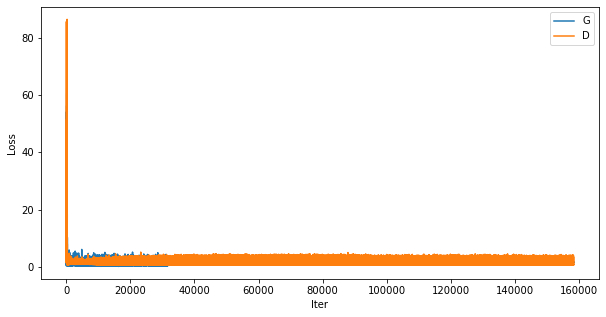

In [8]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

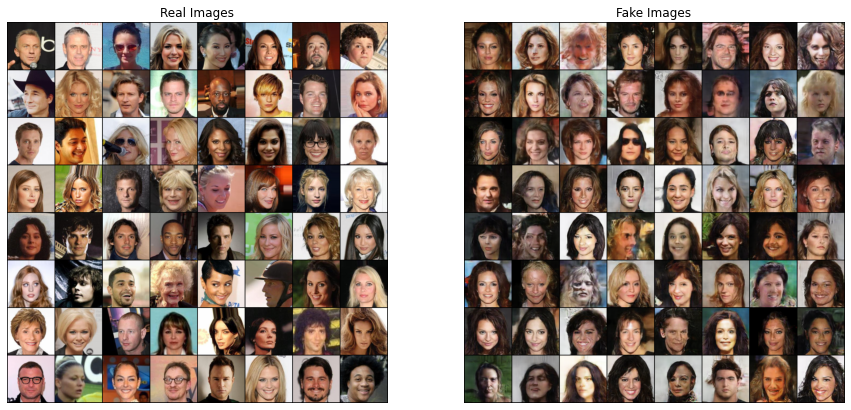

In [8]:
# check images
real_images = next(iter(train_dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Real Images")

plt.subplot(1,2,2)
fake_images = net_G(fixed_noise).detach().cpu()
fake_images = np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True),(1,2,0))
plt.imshow(fake_images)
plt.axis("off")
plt.title("Fake Images")
plt.show()

In [9]:
#Save
state = {
    'net': net_D.state_dict(),
    'acc': 0,
    'epoch': num_epochs,
}
if not os.path.isdir('checkpoint/exp8'):
    os.mkdir('checkpoint/exp8')
torch.save(state, './checkpoint/exp8/ckpt.pth')